# Lab 1 : Working with Optimizers and Convolutional Neural Networks

---

Total Points: **60**

Tentative Weightage : **10%**

Submission Deadline : **11th September 2020, 23:59 hours**

---
**General Instructions:**

---
1. You have to do this lab individually
2. You may use either Tensorflow 2.x or PyTorch framework
3. Please start **early** as the experiments may take time to run
4. All the code should be submitted in the form of a single Jupyter notebook itself.
5. Points for each sub-section are mentioned in the appropriate question.
6. You can use Google colab to run a jupyter notebook (https://colab.research.google.com/) How to load data in Google Colab ?(https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92) (https://www.marktechpost.com/2019/06/07/how-to-connect-google-colab-with-google-drive/)
7. The lab must be submitted on **Google classroom**. The code as well as the accompanying observations should be made part of the python notebook.
8. **Code Readability** is very important. Modularize your code by making use of classes, functions that can be flexibly reused wherever necessary. Also use self explanatory variable names and add comments to describe your approach wherever necessary. You may add additional code or text blocks as necessary. 
9.You are expected to submit your **detailed inferences** (preferably in a text block) and not just an error free code.
10. Students are expected to follow the **honor code** of the class.

In [113]:
# Import the necessary libraries 
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Optimizers(Total for this subsection : **30 points**)
---
The aim of this section is to understand the loss surface of the neural network and study the behaviour of various optimization algorithms on it.

## To do

---
1. Study and implement: 
  *   Mini-batch gradient descent       **{2 points}**
  *   RMSProp [1]                       **{2 points}**
  *   Nesterov Accelerated Gradient [2] **{2 points}**
  *   ADAM [4]                          **{2 points}**

 on a two dimensional fuction like $f(w_1,w_2)=a_1(w_1-b_1)^2 +a_2(w_2-b_2)^2+c$ where $a_1,a_2,b_1,b_2$ and $c$ are hyperparameters which affect the rate of convergence of these algorithms.
2. Experiment these optimization techniques on the non-convex function(s)  (functions having saddle points and local minima's) to illustrate the effectiveness of each of these techniques. **{3 points}**
3. Show the optimization progress on mesh and contour plots. **{2+2=4 points}**
4. Are there any limitations of these algorithms (specifically ADAM)? **{3 points}**
5. What could be the characteristics of a better optimizer to overcome the limitations in Q4 ? **{2 points}**
6. Design your own optimizer and compare it with ADAM. **{6+4=10 points}**

---
**Note 1:** It is alright if your optimizer cannot overperform state of the art optimizer ADAM. But you are expected to have a clear insight of each component of your proposed optimizer.

**Note 2:** Clearly cite the refrenced material.
<!-- But you will have to do a comparative analysis of the proposed optimizer and ADAM. -->

---
References:
1. Tieleman, Tijmen and Hinton, Geoffrey (2012). Lecture 6.5-rmsprop: Divide
the gradient by a running average of its recent magnitude. COURSERA:
Neural Networks for Machine Learning.
2. Nesterov, Y. (1983). A method for unconstrained convex minimization
problem with the rate of convergence o(1/k2). Doklady ANSSSR (translated
as Soviet.Math.Docl.), vol. 269, pp. 543– 547
2121–2159.
3. Kingma, D. P., & Ba, J. L. (2015). Adam: a Method for Stochastic
Optimization. International Conference on Learning Representations, 1–13



##Define the hyperparameters

In [114]:
a1=1.0
a2=1.0
b1=0.0
b2=0.0
c=0.0

##Plot the loss function surface

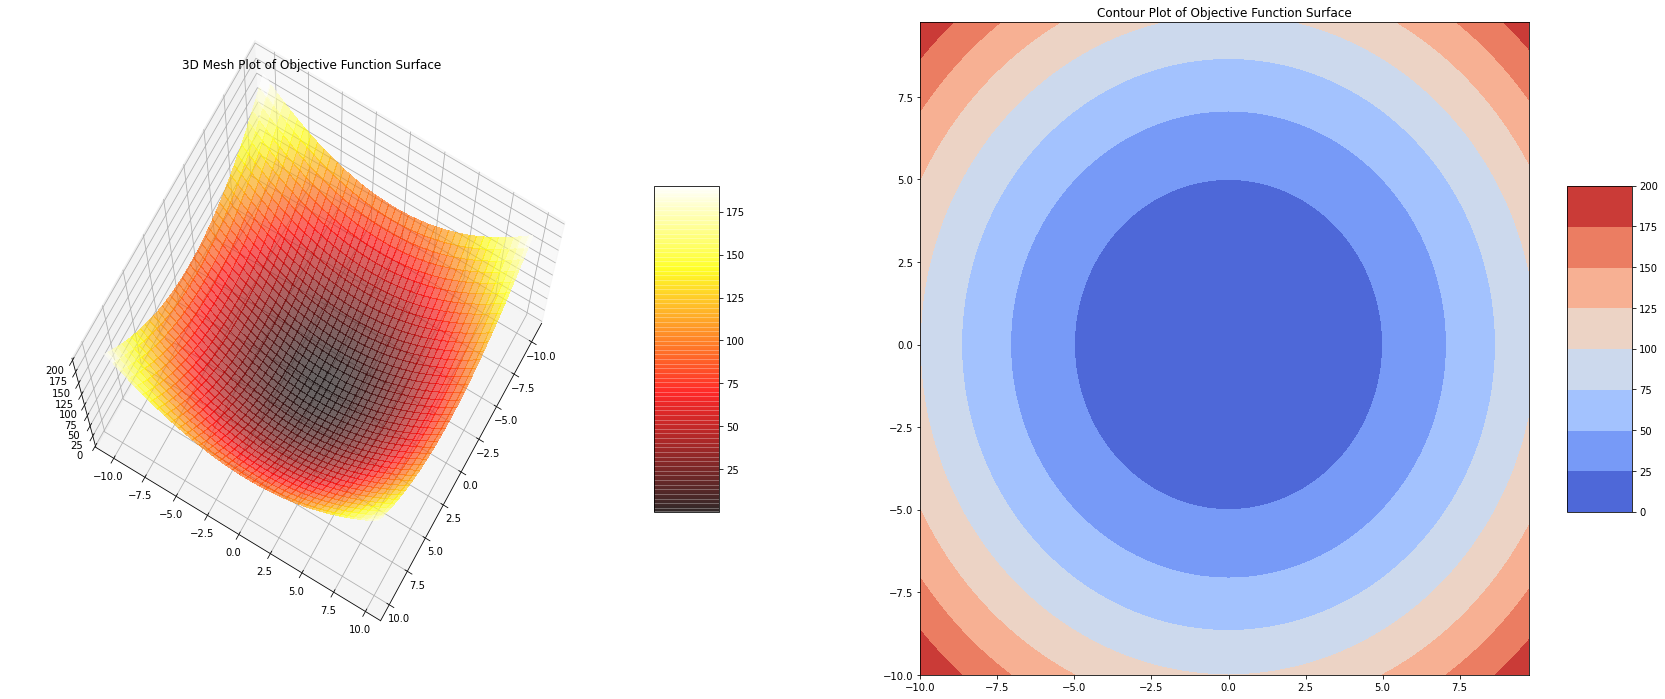

In [126]:
def get_output(w1_samples, w2_samples):
  return a1*((w1_samples-b1)**2) + a2*((w2_samples-b2)**2) + c

fig = plt.figure(figsize=(30, 12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
# ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-10, 10, 0.25)
Y = np.arange(-10, 10, 0.25)
X, Y = np.meshgrid(X, Y)
Z = get_output(X, Y)

# Plot the surface.
ax.view_init(75, 30)
surf = ax.plot_surface(X, Y, Z, cmap=cm.hot, linewidth=0, antialiased=False, alpha=0.6)
ax.set_title('3D Mesh Plot of Objective Function Surface')


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

ax = fig.add_subplot(1, 2, 2)
ax.set_title('Contour Plot of Objective Function Surface')
surf = ax.contourf(X, Y, Z, cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5)


# Convolutional Neural Networks (Total for this subsection : **30 points**)

---
In this section we will work with dog breeds classification. The dataset can be downloaded from Kaggle at (https://www.kaggle.com/samcrochet/p29crosspuredogs). There are 15 breeds of dogs in this dataset. Train, Validation and Test split as provided in the dataset can be used.

## To do

---
1. Download the pretrained model (VGG, ResNet, DenseNet, etc.) from the Keras or TorchVision library. {**1 point**}
2. Modify the final fully connected layer to accomodate 15 classes. {**1 point**}
3. Finetune the model to classify the given dataset of 15 dog breeds. {**10 points**}
4. Use the validation set to get the optimal hyperparameters so as to achieve high validation accuracy. In case you are adopting any other strategies like Data Augmentation to increase the accuracy, kindly mention the same in the jupyter notebook. {**5 points**}
5. Now use the test set to assess the generalization ability of the fine tuned model. Report the accuracy of the trained CNN on the test set. {**1 Point**}
6. You may refer to the Research Paper by Selvaraju et al.[5] for a technique to explain the working of a CNN by visualizing the region of the image that the CNN is looking at, in order to make the prediction.
7. Implement the Grad-CAM methodolgy by Selvaraju et al.[5] to visualize which regions of the test image is seminal to the classifier's output. {**10 points**}
8. In Selvaraju et al.[5], a methodology to verify the correctness of the explanations leveraging the ground truth bounding boxes has been proposed. In a dataset as we used in this lab, where such annotations are not available, Can you think of a way to verify the correctness of the explanation generated? (Implementation not needed. Just discuss the methodology you think is suitable to verify the correctness of the generated explanations.) {**2 points**}



---
**Reference:**

[5]. Ramprasaath R. Selvaraju, Michael Cogswell, Abhishek Das, Ramakrishna
Vedantam, Devi Parikh, Dhruv Batra; Grad-CAM: Visual Explanations From
Deep Networks via Gradient-Based Localization, The IEEE International
Conference on Computer Vision (ICCV), 2017, pp. 618-626.

In [ ]:
# all CNN exercises to come here after
